# Data Gathering and Preprocessing – MRL Infrared Dataset

This notebook:
- Verifies the MRL infrared eye dataset structure and class balance.
- Explores basic properties such as image counts and resolutions.
- Builds a clean TensorFlow `tf.data` pipeline (train / val / test) with preprocessing and light augmentation.

The goal is to prepare the data pipeline we will reuse for modelling (CNN and later CNN+LSTM).


### Imports and Basic Setup

In [6]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras

print("Python version:", os.sys.version)
print("TensorFlow version:", tf.__version__)

# Optional: check GPU
print("GPUs available:", tf.config.list_physical_devices("GPU"))

2025-12-02 22:37:36.864370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764715057.848735  108851 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764715058.148734  108851 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764715060.764557  108851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764715060.764596  108851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764715060.764600  108851 computation_placer.cc:177] computation placer alr

Python version: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Path and directories

In [7]:
# Ensure we are in project root
# If this prints something like .../Deep-Learning-Drowsiness-Prediction, we are good.
print("Current working directory:", os.getcwd())

# If needed, uncomment and adjust:
# os.chdir("/mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction")

mrl_root = "Data/MRL/data"
eye_root = "Data/Eye Dataset/train_dataset"  # for later; main focus is MRL

print("MRL root:", os.path.abspath(mrl_root))
print("Eye root:", os.path.abspath(eye_root))

# Collect all MRL image paths
mrl_paths = glob(os.path.join(mrl_root, "**", "*.png"), recursive=True)
print("Total MRL images:", len(mrl_paths))

Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
MRL root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/MRL/data
Eye root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/Eye Dataset/train_dataset
Total MRL images: 84898


### Counts per class (Awake vs Sleepy) and split

In [8]:
# 3. Image counts per split and class (awake vs sleepy)

import pathlib

def count_images_in_dir(dir_path):
    dir_path = pathlib.Path(dir_path)
    return sum(1 for _ in dir_path.rglob("*.png"))

splits = ["train", "val", "test"]
classes = ["awake", "sleepy"]

rows = []
for split in splits:
    for cls in classes:
        folder = os.path.join(mrl_root, split, cls)
        n = count_images_in_dir(folder)
        rows.append({"split": split, "class": cls, "count": n})

counts_df = pd.DataFrame(rows)
counts_df["total_in_split"] = counts_df.groupby("split")["count"].transform("sum")
counts_df["class_ratio"] = counts_df["count"] / counts_df["total_in_split"]

counts_df

,split,class,count,total_in_split,class_ratio
0,train,awake,25770,50937,0.505919
1,train,sleepy,25167,50937,0.494081
2,val,awake,8591,16980,0.505948
3,val,sleepy,8389,16980,0.494052
4,test,awake,8591,16981,0.505918
5,test,sleepy,8390,16981,0.494082


### Image resolution exploration


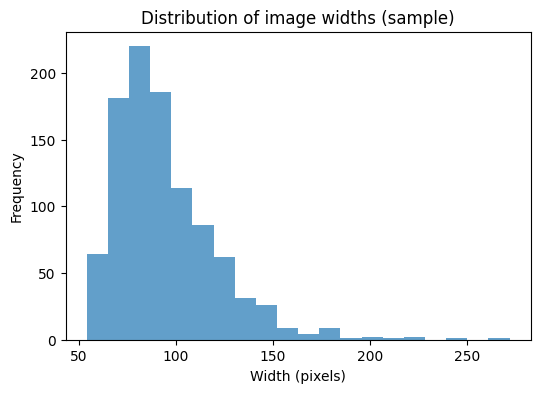

In [10]:
import random

sample_paths = random.sample(mrl_paths, k=min(1000, len(mrl_paths)))

sizes = []
for path in sample_paths:
    with Image.open(path) as img:
        sizes.append(img.size)  # (width, height)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
sizes_df["count"] = 1

size_counts = (
    sizes_df
    .groupby(["width", "height"])["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
)

size_counts.head(10)


plt.figure(figsize=(6,4))
plt.hist(sizes_df["width"], bins=20, alpha=0.7)
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of image widths (sample)")
plt.show()

### Examples of images

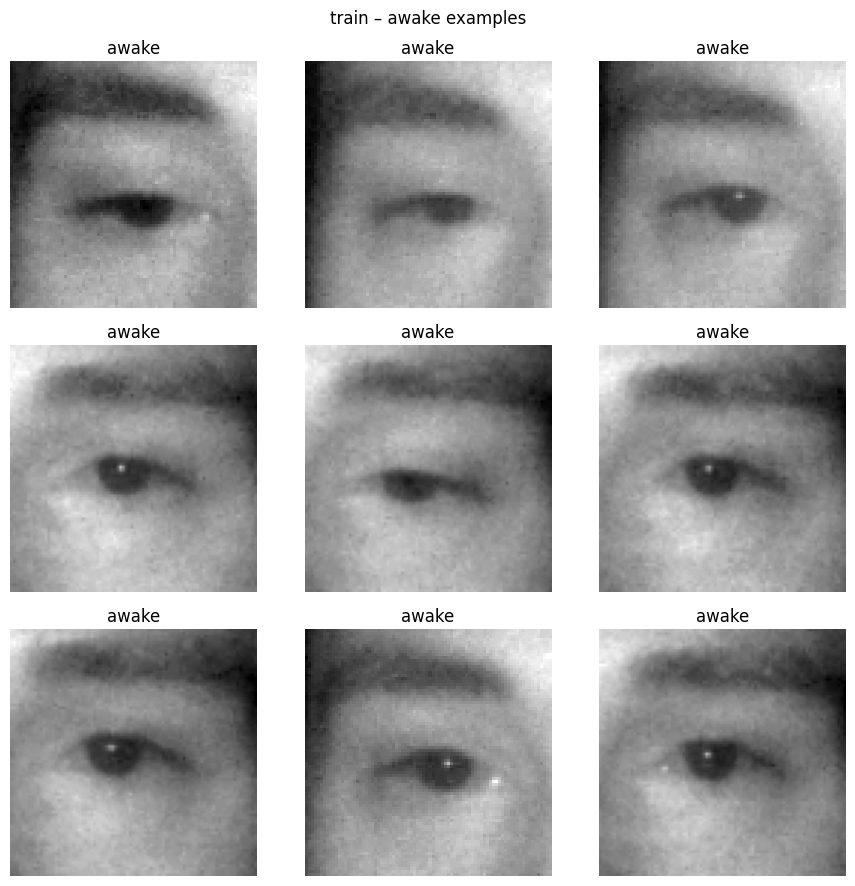

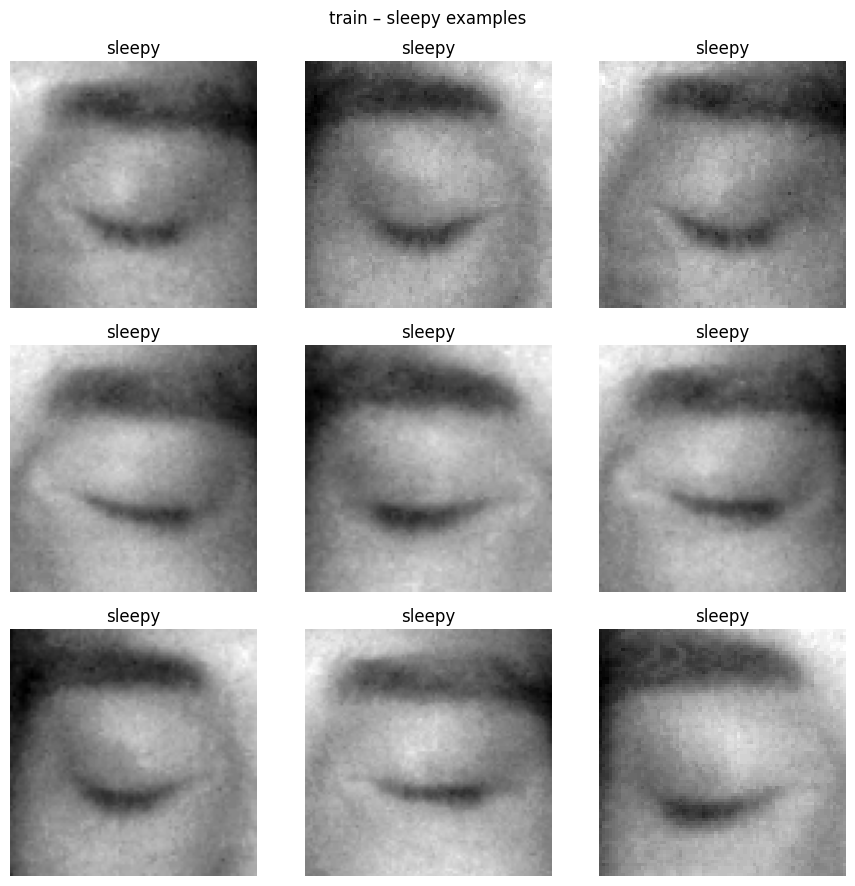

In [11]:
def show_examples(split="train", cls="awake", n=9):
    folder = os.path.join(mrl_root, split, cls)
    paths = glob(os.path.join(folder, "*.png"))
    paths = paths[:n]

    cols = 3
    rows = int(np.ceil(len(paths) / cols))
    plt.figure(figsize=(3*cols, 3*rows))

    for i, p in enumerate(paths):
        with Image.open(p) as img:
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(cls)

    plt.suptitle(f"{split} – {cls} examples")
    plt.tight_layout()
    plt.show()

show_examples("train", "awake", n=9)
show_examples("train", "sleepy", n=9)

### Tensorflow Datasets

In [12]:
IMG_SIZE = (64, 64)   # design choice: small but enough detail
BATCH_SIZE = 64

train_dir = os.path.join(mrl_root, "train")
val_dir   = os.path.join(mrl_root, "val")
test_dir  = os.path.join(mrl_root, "test")

base_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE
)

base_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE
)

base_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Class names:", base_train_ds.class_names)

for images, labels in base_train_ds.take(1):
    print("Raw image batch shape:", images.shape)
    print("Raw label batch shape:", labels.shape)
    break

Found 50937 files belonging to 2 classes.


I0000 00:00:1764715484.486413  108851 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Found 16980 files belonging to 2 classes.
Found 16981 files belonging to 2 classes.
Class names: ['awake', 'sleepy']
Raw image batch shape: (64, 64, 64, 1)
Raw label batch shape: (64, 1)


### Preprocessing and Augmentation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Light augmentations: only for training
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
])

def preprocess(image, label, training=False):
    # uint8 [0,255] -> float32 [0,1]
    image = tf.cast(image, tf.float32) / 255.0

    if training:
        image = data_augmentation(image, training=True)

    return image, label

def prepare_dataset(ds, training=False):
    ds = ds.map(
        lambda x, y: preprocess(x, y, training=training),
        num_parallel_calls=AUTOTUNE
    )
    if training:
        ds = ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(base_train_ds, training=True)
val_ds   = prepare_dataset(base_val_ds,   training=False)
test_ds  = prepare_dataset(base_test_ds,  training=False)

### Check

2025-12-02 22:53:31.780733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-12-02 22:53:41.877428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 50 of 1000
2025-12-02 22:54:01.811097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 104 of 1000
2025-12-02 22:54:21.723033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 159 of 1000
2025-12-02 22:54:31.837779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 187 of 1000
2025-12-02 22:54:51.788393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a wh

Preprocessed image batch shape: (64, 64, 64, 1)
Preprocessed label batch shape: (64, 1)
Pixel range: 0.015661319717764854 -> 1.0


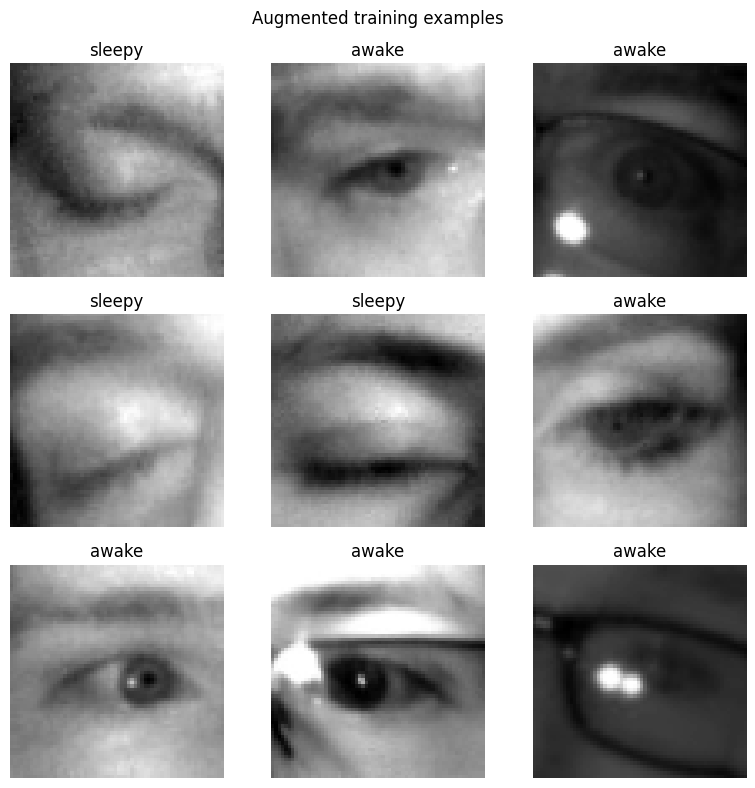

In [14]:
# ==== Sanity check: preprocessed + augmented batch ====

images_batch, labels_batch = next(iter(train_ds))

print("Preprocessed image batch shape:", images_batch.shape)
print("Preprocessed label batch shape:", labels_batch.shape)
print("Pixel range:", float(tf.reduce_min(images_batch)), "->", float(tf.reduce_max(images_batch)))

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i, :, :, 0], cmap="gray")
    plt.title("awake" if labels_batch[i].numpy() == 0 else "sleepy")
    plt.axis("off")
plt.suptitle("Augmented training examples")
plt.tight_layout()
plt.show()